# Hybrid Mutual Information Estimators

In this example we showcase the limitation of a generative estimator (`DoE`) and a discriminative estimator (`MINE`), then show how to combine generative and generative approaches to obtain better estimates.


In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch_mist.data.multimixture import MultivariateCorrelatedNormalMixture
from torch_mist.utils import train_mi_estimator
import pandas as pd

sns.set_style('whitegrid')
IMG_SIZE=3
n_dim = 5

train_parameters = dict(
    max_epochs=20,
    batch_size= 64,
    verbose=True,
    valid_percentage=0,
    lr_annealing=False,
    optimizer_params={'lr':5e-4}
)

# Definition of the distribution
p_XY = MultivariateCorrelatedNormalMixture(n_dim=n_dim)

true_mi = p_XY.mutual_information('x','y')

p_Y_given_X = p_XY.conditional('x')
p_Y = p_XY.marginal('y')

samples = p_XY.sample([100000])

## Generative Estimators: High Bias

One of the main problems of generative mutual information estimation lies in the modeling for $q_\theta(y|x)$ and the approximation of $H(y)$.
In particular lack of flexibility for the model of $q_\theta(y|x)$ yields under-estimation of mutual information.

We start by considering a simple difference of entropies estimator (`DoE`) in which $q_\theta(y|x)$ is modeled with a conditional linear transformation of a Normal distribution, while $r_\psi(y)$ is modeled with a parametric spline transform.

In [2]:
from torch_mist.utils.logging import PandasLogger
from torch_mist.utils.logging.metrics import compute_mean_std

from torch_mist.estimators import doe

estimators = {}
estimators['DoE']=doe(
    x_dim=n_dim,
    y_dim=n_dim,
    hidden_dims=[256, 128],
    conditional_transform_name='conditional_linear',
    marginal_transform_name='spline',
)

# Define a custom logger that computes mean and standard deviation of the log_ratio and batch_loss methods
logger = PandasLogger()
with logger.logged_methods(
    instance=estimators['DoE'],
    methods=[
        ('log_ratio', compute_mean_std),
        ('batch_loss', compute_mean_std)
    ]
):
    doe_log = train_mi_estimator(
        estimator=estimators['DoE'],
        x=samples['x'],
        y=samples['y'],
        logger=logger,
        **train_parameters
    )

doe_log['estimator'] = 'DoE'
log = doe_log

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

We can observe that the `DoE` estimator does not approach the true value of mutual information for this task. This is due to the lack of flexibility of $q_\theta(y|x)$.

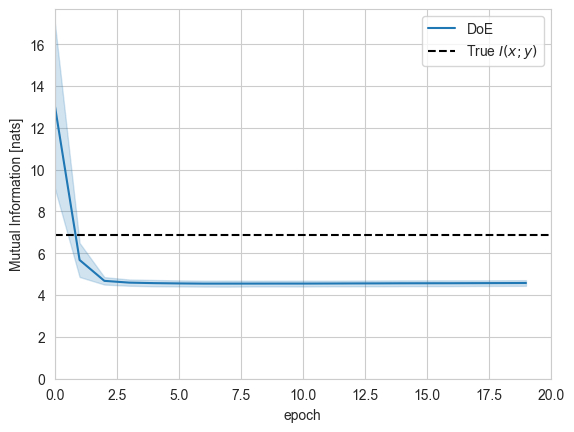

In [3]:
sns.lineplot(log[log['name']=='log_ratio'], x='epoch', y='mean', hue='estimator', ci='sd')
plt.axhline(y=true_mi, ls='--', color='k', label='True $I(x;y)$')
plt.ylim(0,)
plt.xlim(0,20)
plt.ylabel('Mutual Information [nats]')
plt.legend();

Similarly, we can instantiate and train a `PQ` estimator, which is based on modeling $q_\theta(\overline{y}|x)$ and $q_\psi(\overline{y})$ for a discretized $\overline{y}=Q_y(y)$.

In [4]:
from torch_mist.estimators import pq
from torch_mist.quantization import kmeans_quantization

# Quantize y using K-means
Q_y = kmeans_quantization(
    data=samples['y'],
    n_bins=32
)

estimators['PQ']=pq(
    x_dim=n_dim,
    Q_y=Q_y,
    hidden_dims=[256, 128],
)

logger = PandasLogger()
with logger.logged_methods(
    instance=estimators['PQ'],
    methods=[
        ('log_ratio', compute_mean_std),
        ('batch_loss', compute_mean_std)
    ]
):
    pq_log = train_mi_estimator(
        estimator=estimators['PQ'],
        x=samples['x'],
        y=samples['y'],
        logger=logger,
        **train_parameters
    )

pq_log['estimator'] = 'PQ'
log = pd.concat([log, pq_log])

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

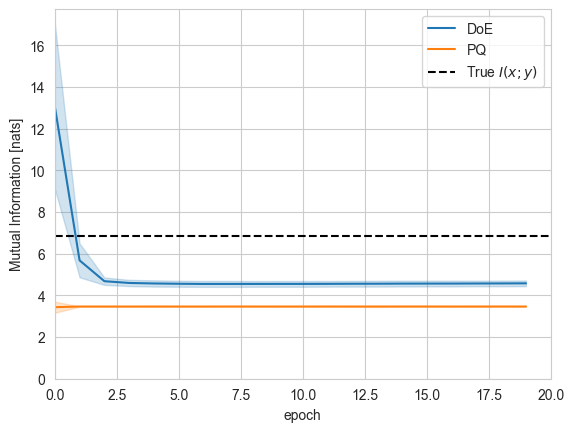

In [5]:
sns.lineplot(log[log['name']=='log_ratio'], x='epoch', y='mean', hue='estimator', ci='sd')
plt.axhline(y=true_mi, ls='--', color='k', label='True $I(x;y)$')
plt.ylim(0,)
plt.xlim(0,20)
plt.ylabel('Mutual Information [nats]')
plt.legend();

## Discriminative Estimators: High Variance

If on the one hand generative estimators are generally not powerful enough to match the true ratio, discriminative estimators are affected by high-variance.
We showcase the issues of discriminative mutual information estimators by computing the mean and variance of the estimates for $\log\frac{p(x,y)}{p(x)p(y)}$ within each training batch. 
For this example we use `MINE` mutual information estimator with a `joint_critic` and 1 negative sample for each positive one.

In [6]:
from torch_mist.estimators import mine

estimators['MINE'] = mine(
    x_dim=n_dim,
    y_dim=n_dim,
    hidden_dims=[256, 128],
    neg_samples=1
)

logger = PandasLogger()

with logger.logged_methods(
    instance=estimators['MINE'],
    methods=[
        ('log_ratio', compute_mean_std),
        ('batch_loss', compute_mean_std)
    ]
):
    mine_log = train_mi_estimator(
        estimator=estimators['MINE'],
        x=samples['x'],
        y=samples['y'],
        logger=logger,
        **train_parameters
    )

mine_log['estimator'] = 'MINE'
log = pd.concat([log, mine_log])

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

We can observe that the `MINE` estimator does not approach the true value of mutual information for this task.

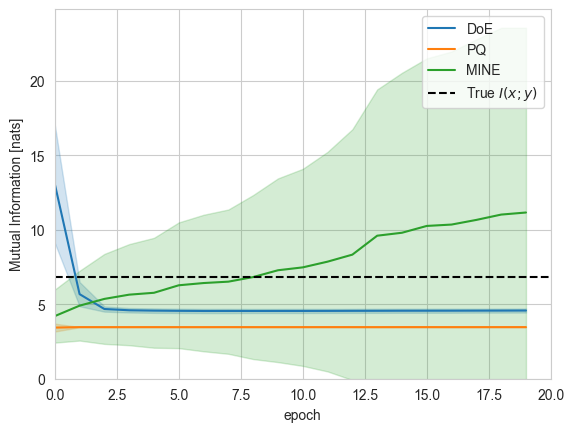

In [7]:
sns.lineplot(log[log['name']=='log_ratio'], x='epoch', y='mean', hue='estimator', ci='sd')
plt.axhline(y=true_mi, ls='--', color='k', label='True $I(x;y)$')
plt.ylim(0,)
plt.xlim(0,20)
plt.ylabel('Mutual Information [nats]')
plt.legend();

Note that the `MINE` estimator has considerable variance for both loss and log-ratio estimation when compared to the generative counterpart.

## Hybrid mutual information estimation

By combining normalized and unnormalized distributions, we can define a more general class of estimators that can take advantage of the low variance of generative estimators and the flexibility of the discriminative approaches.

We start by defining a variational distribution $q_\theta(y|x)$ as the product of a learnable proposal $r_\theta(y|x)$ and an energy $F_\theta(x,y)$:
$$
q_\theta(y|x) = \frac{r_\theta(y|x) e^{F_\theta(x,y)}}{\int r_\theta(y|x)e^{F_\theta(x,y)}dy}
$$

Using the expression for $q_\theta(y|x)$, we can derive the following estimator:
$$
I(x;y)\ge \underbrace{\mathbb{E}_{p(x,y)}\left[\log\frac{r_\theta(y|x)}{p(y)}\right]}_{\text{Generative estimation}} + \underbrace{\mathbb{E}_{p(x,y)}\left[F_\theta(x,y)\right] - \mathbb{E}_{p(x)r_\theta(y|x)}\left[e^{F_\theta(x,y)}\right]+1}_{\text{Discriminative estimation}}.
$$
The first part of the expression is equivalent to the mutual information lower bound obtained with a generative mutual information estimation (e.g. DoE, BA, CLUB,...), while the second component has a similar expression to the discriminative approaches (e.g. MINE, NWJ, SMILE, ...), with one crucial difference.
When computing the partition function (last term), the samples are not drawn from the product distribution $p(x)p(y)$, but from the proposal $p(x)r_\theta(y|x)$ instead.
Whenever $r_\theta(y|x)$ approaches $p(y|x)$, the variance of the estimation for the normalization constant decreases, addressing one of the main issues with discriminative estimators.


### Hybrid: Difference of Entropies + MINE

We show that the two estimators can be combined using the expression above. In particular, we fix the `DoE` estimator and fine-tune the `MINE` to model the ratio between $\log\frac{p(y|x)}{q_\theta(y|x)}$ instead of $\log\frac{p(y|x)}{p(y)}$. This can be easily done by passing the two estimator to the `HybridMIEstimator` class which takes care of combining the estimates, using $r_\theta(y|x)$ instead of $p(y)$ to draw negative samples.

In [8]:
from torch_mist.utils.freeze import freeze
from torch_mist.estimators.hybrid import ResampledHybridMIEstimator
from copy import deepcopy

# Initialize the hybrid mutual information estimator. We re-use the pre-trained DoE and MINE estimators
# Since DoE has been already trained to converge, we can freeze it to speed up the computation, which
# will focus on updating the MINE estimator with negatives drawn from r(y|x) instead of p(y).
estimators['DoE+MINE'] = ResampledHybridMIEstimator(
    generative_estimator=freeze(estimators['DoE']),
    discriminative_estimator=deepcopy(estimators['MINE'])
)

logger = PandasLogger()
with logger.logged_methods(
    instance=estimators['DoE+MINE'],
    methods=[
        ('log_ratio', compute_mean_std),
        ('batch_loss', compute_mean_std)
    ]
):
    hybrid_log = train_mi_estimator(
        estimator=estimators['DoE+MINE'],
        x=samples['x'],
        y=samples['y'],
        logger=logger,
        **train_parameters
    )

hybrid_log['estimator'] = 'DoE+MINE'
log = pd.concat([log, hybrid_log])

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

We can see that our hybrid architecture results in much more accurate estimates that slowly approach the ground-truth mutual information value.

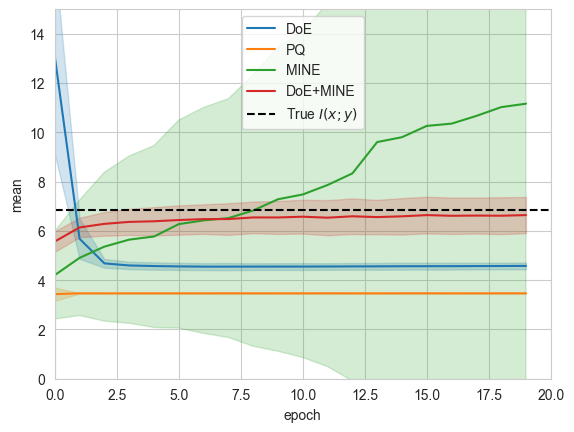

In [9]:
sns.lineplot(log[log['name']=='log_ratio'], x='epoch', y='mean', hue='estimator', errorbar='sd')
plt.axhline(y=true_mi, ls='--', color='k', label='True $I(x;y)$')
plt.ylim(0,15)
plt.xlim(0,20)
plt.legend()

### Hybrid: Predictive Quantization and hard-negatives.

Among the various choices for the proposal $r(y|x)$ we can consider $p(y|\overline{x})$, in which $\overline x$ corresponds to a quantized version of $x$. In other words, we consider $y$ for which the corresponding $x$ maps into the same quantization $\overline x$:
$$
r(y|x) = p(y|\overline{x}) = \int p(x,y|\overline{x}) dx = \mathbb{E}_{p(x|\overline{x})}[p(y|x)] , 
$$
in which $p(x|\overline{x})$ refer to the distribution of all the $x$ that are discretized to $\overline x$.

Using this proposal, we obtain:
$$
I(x;y)\ge \underbrace{\mathbb{E}_{p(x,y)}\left[\log\frac{p(\overline{x}|y)}{p(\overline{x}))}\right]}_{\text{Predictive Quantization Generative estimate}} + \underbrace{\mathbb{E}_{p(x,y)}\left[F_\theta(x,y)\right] - \mathbb{E}_{p(x)p(y|\overline{x})}\left[e^{F_\theta(x,y)}\right]-1}_{\text{Discriminative Estimate with hard negatives}}.
$$
The first term corresponds to the `PQ` generative estimates, which can be seen as a difference of discrete entropies, that are easier to estimate. The second terms corresponds to a discriminative estimate in which the negatives are drown from $p(x)p(y|\overline{x})$ instead of $p(x)p(y)$. This is analogous to the concept of hard negative sampling, since we sample a batch of $y$ for which the corresponding $x$ maps to the same $\overline x$.

Since mutual information is symmetric, and, by convention, we defined all mutual information estimators assuming that $y$ is lower-dimensional and easier to model, implement a version in which we quantize $y$ into $\overline y$ instead, and consider $x$ with the same $\overline y$ as negatives. We do this by first sampling one $\overline{y}$ then creating batches of pairs $(x_i,y_i)$ with $y_i$ that correspond to the sampled $\overline y$.

$$
I(x;y)\ge \mathbb{E}_{p(\overline y)}\left[\mathbb{E}_{p(x,y|\overline y)}\left[\log\frac{p(\overline{y}|x)}{p(\overline{y}))}\right] + \mathbb{E}_{p(x, y|\overline y)}\left[F_\theta(x,y)\right] - \mathbb{E}_{p(x|\overline{y})p(y|\overline{y})}\left[e^{F_\theta(x,y)}\right]-1 \right].
$$

In [10]:
from torch_mist.estimators.hybrid import PQHybridMIEstimator

# We define the hybrid PQ+MINE estimator using the same MINE discriminative estimator and PQ generative estimators trained before
estimators['PQ+MINE'] = PQHybridMIEstimator(
    pq_estimator=freeze(estimators['PQ']),
    discriminative_estimator=deepcopy(estimators['MINE'])
)

logger = PandasLogger()
with logger.logged_methods(
    instance=estimators['PQ+MINE'],
    methods=[
        ('log_ratio', compute_mean_std),
        ('batch_loss', compute_mean_std)
    ]
):
    # Note that the train_mi_estimator internally creates data-loader to sample batches of (x_i, y_i) 
    # for which Q(y_i) is the same for the whole batch
    hybrid_log = train_mi_estimator(
        estimator=estimators['PQ+MINE'],
        x=samples['x'],
        y=samples['y'],
        logger=logger,
        **train_parameters
    )

hybrid_log['estimator'] = 'PQ+MINE'
log = pd.concat([log, hybrid_log])


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1562 [00:00<?, ?it/s]

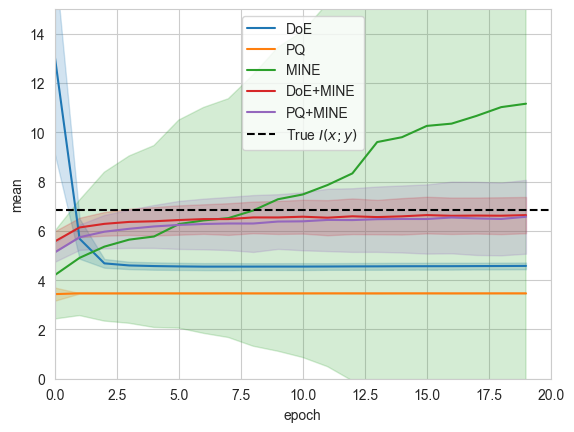

In [11]:
sns.lineplot(log[log['name']=='log_ratio'], x='epoch', y='mean', hue='estimator', errorbar='sd')
plt.axhline(y=true_mi, ls='--', color='k', label='True $I(x;y)$')
plt.ylim(0,15)
plt.xlim(0,20)
plt.legend()

The variance of the hybrid  estimators is indeed lower than `MINE`. This is because the variance for the estimation of the log-partition function grows as $e^{KL(p(y|x)||r(y|x))}$, and the proposal $r(y|x)$ used by the hybrid estimator is closer to the conditional $p(y|x)$ than the marginal $p(y)$.

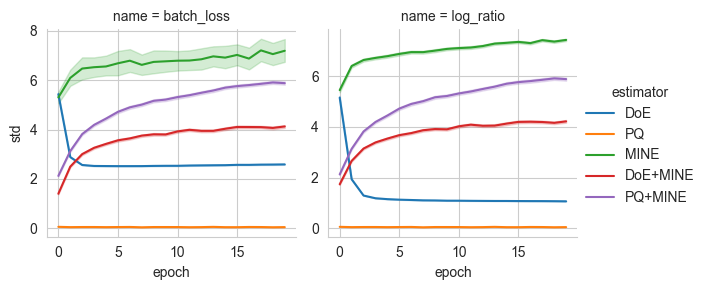

In [14]:
grid = sns.FacetGrid(log, col='name', hue='estimator', sharey=False, sharex=True)
grid.map(sns.lineplot, 'epoch', 'std', errorbar='ci')
grid.add_legend()

We can further showcase the differences between the estimators by plotting the modeled log-ratios.

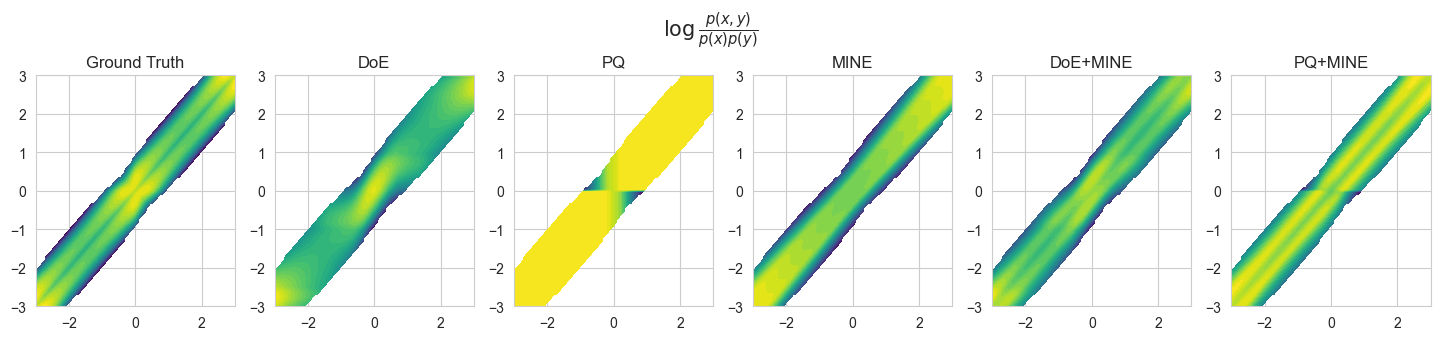

In [13]:
# We create a uniform grid to visualize the functions modeled by conditional distributions
res = 100
x_grid = torch.linspace(-3,3,res).view(1,-1,1)
y_grid = torch.linspace(-3,3, res).view(-1,1,1)
X, Y = np.meshgrid(x_grid, y_grid)

# Compute the true log-ratio log p(x,y)p(x)p(y) on the grid
log_marginal = p_XY.marginal('x').log_prob(x=x_grid)/n_dim +  p_XY.marginal('y').log_prob(y=y_grid)/n_dim
log_joint = p_XY.log_prob(x=x_grid, y=y_grid)/n_dim
# We visualize only the points for which p(x,y) > e^{-20}
mask = (log_joint>-25).data.numpy()
log_ratio = (log_joint - log_marginal).data.numpy()


# Plot the true log p(y|x)
f, ax = plt.subplots(
    1,1+len(estimators),
    figsize=((1+len(estimators))*IMG_SIZE, IMG_SIZE)
)

# Plot the true log-ratio
f.suptitle("$\\log \\frac{p(x,y)}{p(x)p(y)}$", fontsize=15, y=1.1)
ax[0].contourf(X, Y, log_ratio/mask, cmap='viridis', levels=40)
ax[0].set_title('Ground Truth')

for i, (name, estimator) in enumerate(estimators.items()):
    log_ratio = estimator.unnormalized_log_ratio(x_grid.repeat(res,1,n_dim), y_grid.repeat(1,res,n_dim)).data.numpy()/n_dim
        
    ax[i+1].contourf(X, Y, log_ratio/mask, cmap='viridis', levels=40)
    ax[i+1].set_title(name)


It is possible to use the `HybridMIEstimator` class to model combinations of different generative and discriminative estimators (e.g. `BA+SMILE`, `CLUB+JS`, `L1Out+FLO`, ...).